In [104]:
# importando os dados coletados em 23/06/2025 para não usar a API novamente
detailed_patient_df = pd.read_csv("feegow_all_patients_detailed.csv")

/tmp/ipykernel_4207/3975708436.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  detailed_patient_df = pd.read_csv("feegow_all_patients_detailed.csv")


In [105]:
# --- Full Deduplication Workflow using Name and Date of Birth ---

print(f"Original DataFrame shape: {detailed_patient_df.shape}")

# Create a new DataFrame for the cleaned data
df_cleaned = df.copy()

# 1. Remove completely identical rows
df_cleaned.drop_duplicates(inplace=True)
print(f"Shape after removing full duplicates: {df_cleaned.shape}")

# 2. Remove duplicates by 'patient_id', keeping the most recently updated record.
# This is still a critical step to handle primary key duplication.
df_cleaned.sort_values('alterado_em', ascending=False, inplace=True)
df_cleaned.drop_duplicates(subset=['patient_id'], keep='first', inplace=True)
print(f"Shape after removing 'patient_id' duplicates: {df_cleaned.shape}")

# 3. Remove duplicates by 'nome_paciente' & 'data_nascimento', keeping the most recent.
# This handles cases where the same person has multiple patient_ids.

# First, ensure the sorting by 'alterado_em' is still in place from the previous step.
# The 'inplace=True' above ensures this.

# Now, drop duplicates based on the subset, keeping the 'first' (which is the most recent).
# We only consider rows where both name and DoB are present.
subset_cols = ['nome', 'nascimento']
df_cleaned.drop_duplicates(subset=subset_cols, keep='first', inplace=True)
print(f"Shape after removing Name + DoB duplicates: {df_cleaned.shape}")

# --- Final Verification ---
print("\n--- Final Verification ---")
print(f"Original row count: {df.shape[0]}")
print(f"Cleaned row count: {df_cleaned.shape[0]}")
print(f"Total rows removed: {df.shape[0] - df_cleaned.shape[0]}")
print(f"Remaining duplicates on 'patient_id': {df_cleaned['patient_id'].duplicated().sum()}")
print(f"Remaining duplicates on 'nome' & 'nascimento': {df_cleaned.dropna(subset=subset_cols).duplicated(subset=subset_cols).sum()}")

Original DataFrame shape: (36698, 31)
Shape after removing full duplicates: (36698, 31)
Shape after removing 'patient_id' duplicates: (36698, 31)
Shape after removing Name + DoB duplicates: (36223, 31)

--- Final Verification ---
Original row count: 36698
Cleaned row count: 36223
Total rows removed: 475
Remaining duplicates on 'patient_id': 0
Remaining duplicates on 'nome' & 'nascimento': 0


In [106]:
# tirando as colunas que não serão usadas na análise
patient_df = df_cleaned.drop(['documento', 'endereco', 'numero', 'complemento', 
                              'foto','matricula','telefones','celulares',
                              'documentos','email'], axis=1)

In [107]:
# colocando todos os textos em letras minúsculas
for col in patient_df.columns:
    if patient_df[col].dtype == 'object':  # Check if the column contains string data (object dtype)
        patient_df[col] = patient_df[col].str.lower()

In [108]:
# Convert 'criado_em' to datetime objects.
# errors='coerce' will turn any un-parsable values into NaT (Not a Time)
patient_df['criado_em'] = pd.to_datetime(patient_df['criado_em'], errors='coerce')

# Drop any rows where the date conversion failed to avoid errors in plotting
patient_df.dropna(subset=['criado_em'], inplace=True)

print("Data types after conversion:")
patient_df.info()

Data types after conversion:
<class 'pandas.core.frame.DataFrame'>
Index: 36223 entries, 35936 to 1257
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 36223 non-null  int64         
 1   nome               36223 non-null  object        
 2   nome_social        1 non-null      object        
 3   nascimento         28295 non-null  object        
 4   sexo               25816 non-null  object        
 5   origem_id          20972 non-null  float64       
 6   tabela_id          23119 non-null  float64       
 7   bairro             25602 non-null  object        
 8   cidade             22956 non-null  object        
 9   estado             22821 non-null  object        
 10  pais               20373 non-null  float64       
 11  observacao         5912 non-null   object        
 12  cep                20122 non-null  object        
 13  profissao          20 non-null    

In [109]:
# Set 'criado_em' as the DataFrame index to make time-based resampling easy
patient_df.set_index('criado_em', inplace=True)

# Resample the data by month ('M') and count the number of entries in each month.
# .size() counts every row in the group.
monthly_counts = patient_df.resample('M').size()
patient_df.reset_index(inplace=True)

# Convert the result into a DataFrame for easier plotting with Seaborn
monthly_counts_df = monthly_counts.reset_index()
monthly_counts_df.columns = ['creation_month', 'patient_count']

print("\nAggregated patient counts per month:")
print(monthly_counts_df.head())


Aggregated patient counts per month:
  creation_month  patient_count
0     2021-11-30           7243
1     2021-12-31            424
2     2022-01-31            648
3     2022-02-28            545
4     2022-03-31            652


/tmp/ipykernel_4207/1047993773.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = patient_df.resample('M').size()


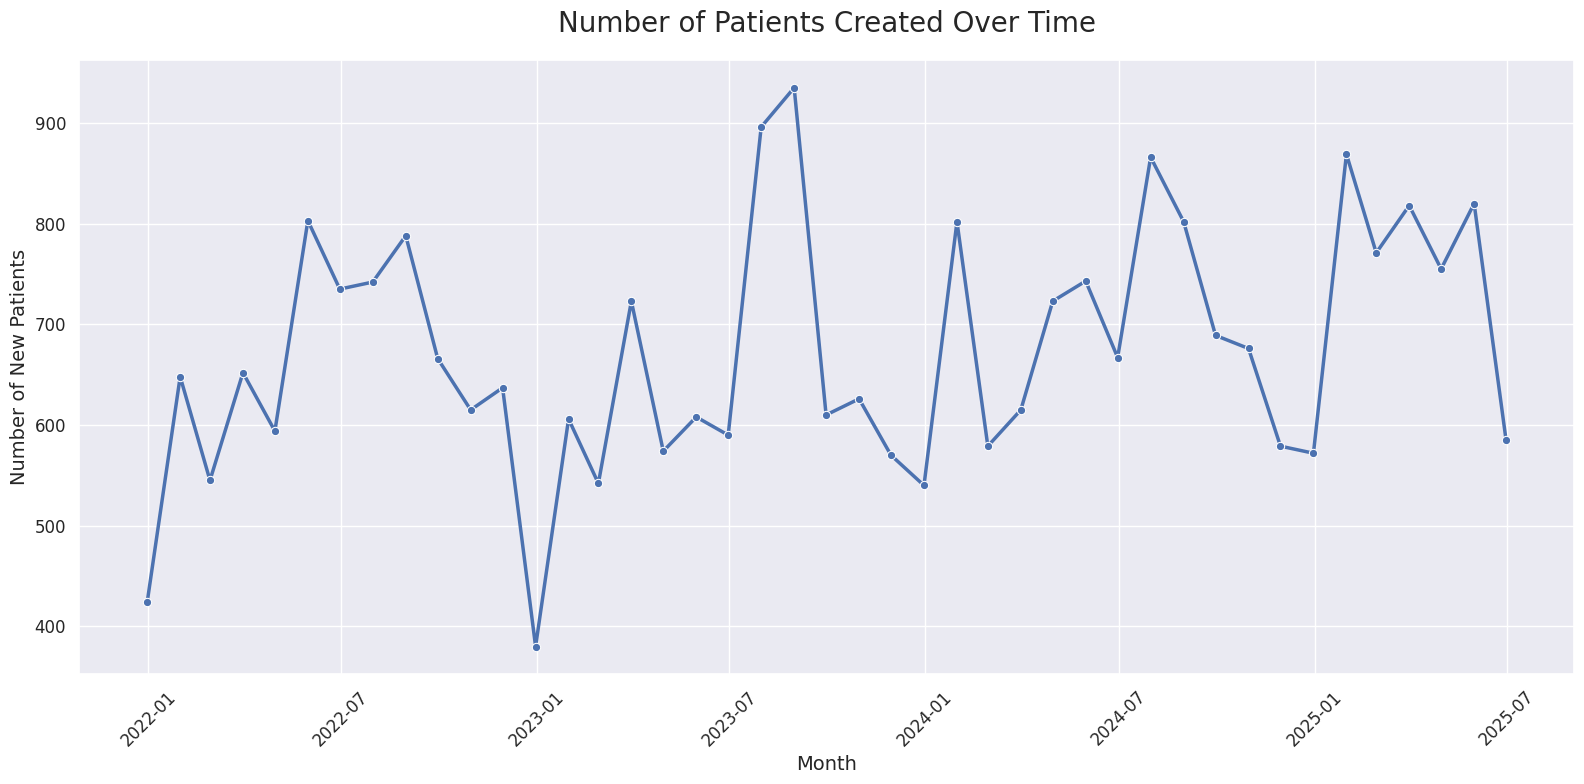

In [100]:
# Set the visual theme for the plot
sns.set_theme(style="darkgrid")

# Create the figure and axes for the plot
plt.figure(figsize=(16, 8))

# Create the line plot
ax = sns.lineplot(
    data=monthly_counts_df[1:],
    x='creation_month',
    y='patient_count',
    marker='o', # Add circles on each data point for clarity
    linewidth=2.5
)

# --- Customize the plot for better readability ---

# Set a clear title and labels
plt.title('Number of Patients Created Over Time', fontsize=20, pad=20)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of New Patients', fontsize=14)

# Improve the formatting of the x-axis date labels
ax.tick_params(axis='x', rotation=45)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Ensure everything fits without overlapping
plt.tight_layout()

# Display the plot
plt.show()

In [140]:
patient_df['bairro'].value_counts()

bairro
flamengo               1635
laranjeiras            1048
catete                  976
centro                  807
copacabana              774
                       ... 
joaquim de oliveira       1
quissama                  1
murique                   1
barra olimpica            1
nilopólis                 1
Name: count, Length: 1267, dtype: int64

In [138]:
# Esta função aplica várias limpezas padrão em uma string.
def normalizar_texto(texto):
    if not isinstance(texto, str):
        return ""
    
    # Converte para minúsculas
    texto = texto.lower()
    
    # Remove acentos (ex: "josé" -> "jose")
    texto = unidecode.unidecode(texto)
    
    # Remove abreviações comuns (adicione outras se necessário)
    substituicoes = {
        'jd.': 'jardim',
        'jd': 'jardim',
        'vl.': 'vila',
        'vl': 'vila',
        'b.': 'bairro',
        'bair ': 'bairro ' # com espaço para não confundir com outras palavras
    }
    for abrev, completo in substituicoes.items():
        texto = texto.replace(abrev, completo)
        
    # Remove pontuações e caracteres especiais, mantendo apenas letras e espaços
    texto = re.sub(r'[^a-zA-Z0-9\s]', '', texto)
    
    # Remove espaços em branco no início e no fim
    texto = texto.strip()
    
    # Substitui múltiplos espaços por um único espaço
    texto = re.sub(r'\s+', ' ', texto)
    
    return texto

In [141]:
# --- 3. PROCESSO DE PADRONIZAÇÃO ---

# Pega uma lista de nomes de bairros únicos e não nulos
bairros_unicos = patient_df['bairro'].dropna().unique()

# Normaliza todos os nomes únicos
bairros_normalizados = {bairro: normalizar_texto(bairro) for bairro in bairros_unicos}

# Inverte o dicionário para agrupar nomes originais por nome normalizado
# Isso já resolve casos como "Jd. Paulista" e "Jardim Paulista"
grupos_normalizados = {}
for original, normalizado in bairros_normalizados.items():
    if normalizado not in grupos_normalizados:
        grupos_normalizados[normalizado] = []
    grupos_normalizados[normalizado].append(original)

print("--- Grupos após a primeira normalização ---")
print(grupos_normalizados)
print("\n" + "="*50 + "\n")


# --- 4. AGRUPAMENTO COM FUZZY MATCHING ---
# Agora, vamos encontrar similaridades entre os nomes já normalizados.

# Lista de nomes únicos já normalizados
chaves_normalizadas = list(grupos_normalizados.keys())

# Dicionário para armazenar o mapeamento final do nome sujo -> nome padrão
mapa_padronizacao = {}
processados = set()

# Limite de similaridade (ajuste conforme necessário, 85 é um bom ponto de partida)
# Quanto maior o valor, mais parecidas as strings precisam ser.
LIMITE_SIMILARIDADE = 85

for nome_base in chaves_normalizadas:
    if nome_base in processados:
        continue

    # Encontra todas as strings na lista que são muito similares à string base
    # O process.extract retorna uma lista de tuplas: (string_encontrada, similaridade, indice)
    matches = process.extract(nome_base, chaves_normalizadas, scorer=fuzz.token_sort_ratio, limit=None, score_cutoff=LIMITE_SIMILARIDADE)

    # O grupo de nomes similares será composto pelos nomes encontrados
    grupo_similar = [match[0] for match in matches]

    # --- Escolha do Nome Padrão para o Grupo ---
    # Critério: O nome mais frequente no DataFrame original.
    frequencias = {}
    nomes_originais_grupo = []
    for nome_similar in grupo_similar:
        # Adiciona todos os nomes originais (antes da normalização) à lista
        nomes_originais_grupo.extend(grupos_normalizados[nome_similar])

    # Conta a frequência de cada nome original no DataFrame
    contagem_total_grupo = patient_df['bairro'].value_counts()
    
    nome_padrao = max(nomes_originais_grupo, key=lambda nome: contagem_total_grupo.get(nome, 0))

    # Atualiza o mapa de padronização e o conjunto de nomes já processados
    for nome_similar in grupo_similar:
        for nome_original_sujo in grupos_normalizados[nome_similar]:
            mapa_padronizacao[nome_original_sujo] = nome_padrao
        processados.add(nome_similar)
        
print("--- Mapa Final de Padronização ---")
print(mapa_padronizacao)
print("\n" + "="*50 + "\n")


# --- 5. APLICAR O MAPA DE VOLTA AO DATAFRAME ---
# Cria a nova coluna 'bairro_padronizado' usando o mapa
patient_df['bairro_padronizado'] = patient_df['bairro'].map(mapa_padronizacao)
patient_df['bairro_padronizado'].value_counts()

--- Grupos após a primeira normalização ---
{'parque duque': ['parque duque'], 'vila sao luis': ['vila são luís', 'vila são luis'], 'catete': ['catete'], 'realengo': ['realengo'], 'barro vermelho': ['barro vermelho'], 'laranjeiras': ['laranjeiras'], 'mangueira': ['mangueira'], 'vila centenario': ['vila centenário'], 'flamengo': ['flamengo'], 'olavo bilac': ['olavo bilac'], 'santa margarida i tamoios': ['santa margarida i (tamoios)'], 'cascadura': ['cascadura'], 'tijuca': ['tijuca'], 'freguesia jacarepagua': ['freguesia (jacarepaguá)', 'freguesia - jacarepaguá', 'freguesia jacarepaguá'], 'campo lindo': ['campo lindo'], 'gardenia azul': ['gardênia azul', 'gardenia azul'], 'ipanema': ['ipanema'], 'grajau': ['grajaú', 'grajau'], 'recreio dos bandeirantes': ['recreio dos bandeirantes'], 'curicica': ['curicica'], 'ilha do governador': ['ilha do governador'], 'pavuna': ['pavuna'], 'madureira': ['madureira'], 'barra olimpica': ['barra olímpica', 'barra olimpíca', 'barra olimpica'], 'benfica': 

--- Mapa Final de Padronização ---
{'parque duque': 'parque duque', 'vila são luís': 'vila são luís', 'vila são luis': 'vila são luís', 'catete': 'catete', 'catet': 'catete', 'realengo': 'realengo', 'barro vermelho': 'barro vermelho', 'laranjeiras': 'laranjeiras', 'laranjeira': 'laranjeiras', 'larajeiras': 'laranjeiras', 'larajeniras': 'laranjeiras', 'laramjeiras': 'laranjeiras', 'laranjeiro': 'laranjeiras', 'mangueira': 'mangueira', 'manguera': 'mangueira', 'vila centenário': 'vila centenário', 'flamengo': 'flamengo', 'flamwengo': 'flamengo', 'flameno': 'flamengo', 'flamnego': 'flamengo', 'olavo bilac': 'olavo bilac', 'santa margarida i (tamoios)': 'santa margarida i (tamoios)', 'cascadura': 'cascadura', 'casca dura': 'cascadura', 'tijuca': 'tijuca', 'freguesia (jacarepaguá)': 'freguesia (jacarepaguá)', 'freguesia - jacarepaguá': 'freguesia (jacarepaguá)', 'freguesia jacarepaguá': 'freguesia (jacarepaguá)', 'freguesia/jacarepaguá': 'freguesia (jacarepaguá)', 'freguesia de jacarepagua'

bairro_padronizado
flamengo            1639
laranjeiras         1055
catete               977
centro               808
copacabana           777
                    ... 
ponte dos leites       1
israel pinheiro        1
lar fluminense         1
parque amorim          1
caramujo               1
Name: count, Length: 1088, dtype: int64

In [144]:
patient_df.columns

Index(['criado_em', 'id', 'nome', 'nome_social', 'nascimento', 'sexo',
       'origem_id', 'tabela_id', 'bairro', 'cidade', 'estado', 'pais',
       'observacao', 'cep', 'profissao', 'indicado_por', 'convenio_id',
       'convenios', 'programa_de_saude', 'alterado_em', 'patient_id',
       'bairro_padronizado'],
      dtype='object')